<p style="font-size:32px; font-weight: bolder; text-align: center"> Path Integral Molecular Dynamics </p>

<p style="text-align: right">Adapted from i-PI tutorials </p>


<div style="background-color: #e6f7ff ; padding: 15px; border-radius: 10px;">

## Goal   
1. Run a short PIMD simulation on the analytical 1D harmonic potential.
2. Analyze different properties.

</div>

In [38]:
# Import required libraries

import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import rfft, irfft
from numpy import linalg as LA

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">


## Path integral molecular dynamics in a harmonic potential

The Hamiltonian of the system can be written as the sum of the kinetic and potential energy terms
$$
\hat{\mathbf{H}} = \hat{\mathbf{T}} + \hat{\mathbf{V}}
$$

For a path-integral molecular dynamics setup the potential energy can be written as a sum over all ring-polymer beads
$$
V(\mathbf{x}) = \sum_{i=1}^P\frac{1}{2}m\omega_P^2 (x_i-x_{i+1})^2 + \sum_{i=1}^P\frac{1}{2} m \lambda^2 x_i^2
$$
where
$$
\omega_P = \frac{P}{\beta \hbar}
$$
is the frequency of the springs connecting neighbouring beads in the Ring Polymer and $\lambda$ is the frequency of the external harmonic potential.
    
</div>

### Setting the physical constants

In [24]:
beta = 1   # The reciprocal temperature
lmbd = 0   # The oscillation frequency of the harmonic potential
hbar = 1   # The Planck constant
m    = 1   # The mass of the simulated particle

### Potential and its derivative

In [25]:
def V(q, lmbd, m):
    """ Function containing the harmonic potential: V(q) = (1/2) * m * lambda^2 * q^2 """
    return 0.5 * m * lmbd**2 * q**2

def dV(q, lmbd, m):
    """ Function containing the first derivative of the harmonic potential: dV/dq """
    return m * lmbd**2 * q

### Initialization

In [26]:
P = 8            # The number of beads in the Ring Polymer

p = np.zeros(P)  # The momentum vector of the ring polymer
q = np.zeros(P)  # The position vector of the ring polymer

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">


## The free ring polymer


The free ring polymer potential energy matrix (discounting the harmonic potential energy term) is not diagonal.

The potential energy term of the "free" ring polymer  is:


$$
\mathbf{x}^T
\begin{pmatrix} 
 m\omega_P^2 & -\frac{m}{2}\omega_P^2 &  0 &  0 & ... & -\frac{m}{2}\omega_P^2 \\
-\frac{m}{2}\omega_P^2 &  m\omega_P^2 & -\frac{m}{2}\omega_P^2 &  0 & ... & 0  \\
 0 & -\frac{m}{2}\omega_P^2 &  m\omega_P^2 & -\frac{m}{2}\omega_P^2 & ... & 0  \\
...&... & ...& ...& ... & ...  \\
-\frac{m}{2}\omega_P^2 &  0 &  0 &  0  & -\frac{m}{2}\omega_P^2  & m\omega_P^2  \\
\end{pmatrix}
\mathbf{x}
$$

or:

$$
\frac{m}{2}\omega_P^2 \mathbf{x}^T
\begin{pmatrix} 
 2 & -1 &  0 &  0 & ... & -1  \\
-1 &  2 & -1 &  0 & ... & 0   \\
 0 & -1 &  2 & -1 & ... & 0   \\
...&... & ...& ...& ... & ... \\
-1 &  0 &  0 &  0  & -1  & 2  \\
\end{pmatrix}
\mathbf{x}
$$
    
</div>

### Compute Normal Mode Frequencies of the Free Ring Polymer

In [27]:
def internalFreq(lmbd, P, beta, hbar, m):
    omegaP = 1/(beta/P)/hbar
    PotMat = np.zeros((P,P)) # Hessian
    intfreq = np.zeros(P)
    
    for i in range(P): # Diagonal terms
        PotMat[i,i] = 1/2 * m * lmbd**2 + 1 * m * omegaP**2 
    for i in range(P-1): # off-Diagonal terms
        PotMat[i,i+1] = - 1/2 * m * omegaP**2
    for i in range(1,P): # off-Diagonal terms
        PotMat[i,i-1] = - 1/2 * m * omegaP**2
    
    # Periodic boundary
    PotMat[0,P-1] = - 1/2 * m * omegaP**2
    PotMat[P-1,0] = - 1/2 * m * omegaP**2
    
    # Diagonalization
    eigvals=sorted(LA.eigvals(PotMat))
   
    # Centroid mode is 0
    if abs(eigvals[0]) < 1e-10:  # take care with numerics of first eigenvalue
        eigvals[0]=0.0

    # Compute frequencies
    intfreq=np.array([np.sqrt(i*2/m) for i in eigvals])
        
    return intfreq

print("The normal mode frequencies of the RP: ", np.round(internalFreq(lmbd, P, beta, hbar, m),3))

The normal mode frequencies of the RP:  [ 0.     6.123  6.123 11.314 11.314 14.782 14.782 16.   ]


<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">


Note: Free Ring Polymer i.e. $\lambda=0$.

Therefore, the eigenvalues are taking the form of $\mathbf{\omega}^2=\frac{m}{2}\{0, (2-\sqrt{2})\omega_P^2, (2-\sqrt{2})\omega_P^2, 2 \omega_P^2, ..., 4 \omega_P^2\} $ which are showing pairwise degeneracies and match the analytical form (similar to 1D phonon model)

$$
   \omega_k = 2 \omega_P \sin{\Big(\frac{k \pi}{P}\Big)}
$$
    
</div>

### Exercise 1: Plot max($\omega_k$) w.r.t. $P$ and $\beta$

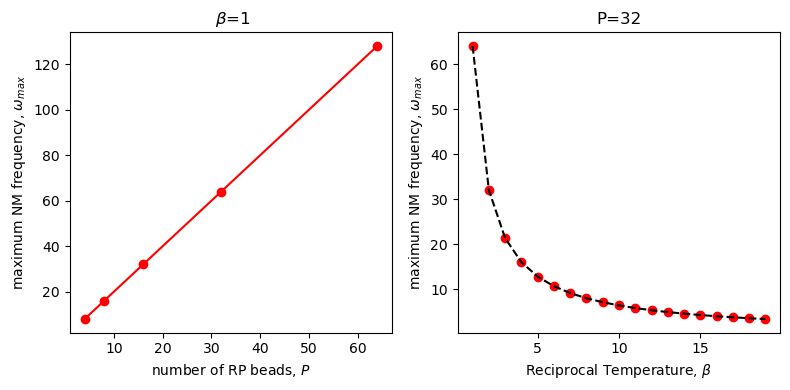

In [28]:
listofP = [4,8,16,32,64]
listofBeta = np.arange(1,20)
listofmaxNM = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

betal = 1
for ip in listofP:
    listofmaxNM.append(np.real(internalFreq(lmbd, ip, betal, hbar, m)[-1])) 
    
ax1.plot(listofP, listofmaxNM, 'o-', color = 'red')
ax1.set_xlabel(r'number of RP beads, $P$')
ax1.set_ylabel(r'maximum NM frequency, $\omega_{max}$')
ax1.set_title(r' $ \beta $=1')

P = 32
listofmaxNM = []
for betal in listofBeta:
    listofmaxNM.append(np.real(internalFreq(lmbd, P, betal, hbar, m)[-1]))
    
ax2.plot(listofBeta, listofmaxNM, 'o', color='red')
ax2.plot(listofBeta, list(64/i for i in listofBeta), '--', color='black')
ax2.set_xlabel(r'Reciprocal Temperature, $ \beta $')
ax2.set_ylabel(r'maximum NM frequency, $\omega_{max}$')
ax2.set_title('P=32')
plt.tight_layout()
plt.show()

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

1. $\omega_{max}$ corresponds to the tightest internal vibration of the ring : it determines the smallest time scale in the dynamics.
2. As $P$ increases (more beads), the polymer can represent more high-frequency modes : hence $\omega_{max}$ increases.
3. As temperature decreases (larger $\beta$), the path "stretches out" in imaginary time : each spring becomes tighter (larger $\omega_P$) to enforce periodicity.
    
</div>

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

## Ring polymer in the harmonic potential


$$
V(x) = \mathbf{x}^T
\begin{pmatrix} 
 m\omega_P^2 + \frac{m}{2}\lambda^2 & -\frac{m}{2}\omega_P^2 &  0 &  0 & ... & -\frac{m}{2}\omega_P^2 \\
-\frac{m}{2}\omega_P^2 &  m\omega_P^2 + \frac{m}{2}\lambda^2  & -\frac{m}{2}\omega_P^2 &  0 & ... & 0  \\
 0 & -\frac{m}{2}\omega_P^2 &  m\omega_P^2 + \frac{m}{2}\lambda^2  & -\frac{m}{2}\omega_P^2 & ... & 0  \\
...&... & ...& ...& ... & ...  \\
-\frac{m}{2}\omega_P^2 &  0 &  0 &  0  & -\frac{m}{2}\omega_P^2  & m\omega_P^2 + \frac{m}{2}\lambda^2   \\
\end{pmatrix}
\mathbf{x}
$$

</div>


### Exercise 2: Vary $\lambda$ for P $\le$ 32, 64 and understand the time scale of ring polymer dynamics

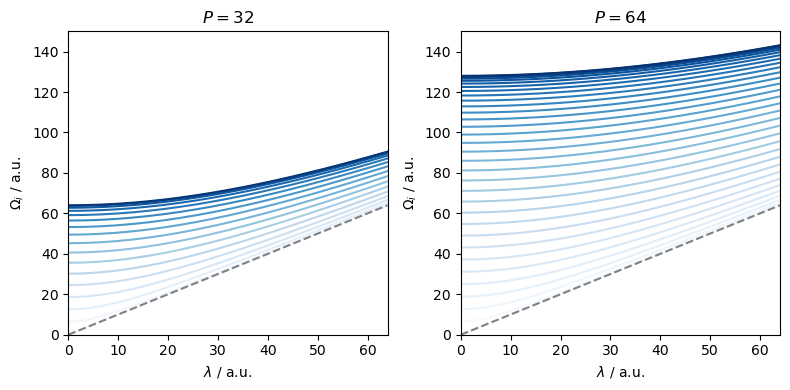

In [29]:
cmap = plt.colormaps['Blues']

# Parameters
m = 1
beta = 1
lmbd = np.linspace(0, 64, 21)

def compute_and_plot(ax, P):
    freqMat = np.array([internalFreq(lb, P, beta, hbar, m) for lb in lmbd])
    for bead in range(P):
        if bead == 0:
            ax.plot(lmbd, freqMat[:, bead], '-', color=cmap(bead / P), label=r'$\omega${bead}')
        elif bead % 2 == 1:
            ax.plot(lmbd, freqMat[:, bead], '-', color=cmap(bead / P), label=r'$\omega${bead//2 + 1}')
    ax.plot(lmbd, lmbd, '--', color='grey')
    ax.set_xlim([0, max(lmbd)])
    ax.set_ylim([0, 150])
    ax.set_xlabel(r'$\lambda$ / a.u.')
    ax.set_ylabel(r'$\Omega_i$ / a.u.')
    ax.set_title(fr'$P={P}$')

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
for ax, P in zip((ax1, ax2), (32, 64)):
    compute_and_plot(ax, P)

plt.tight_layout()
plt.show()

### Exercise 3: Plot normal mode frequency distribution for different values of P

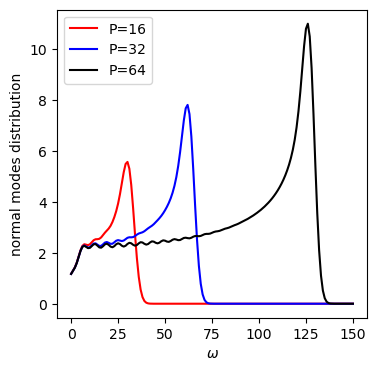

In [30]:
colors = ['red', 'blue', 'black']
fig = plt.subplots(figsize=(4,4))

def gaussian(xx, center, sigma):
    return np.exp(-(xx-center)**2/sigma**2)

lb = 0
for P in [16,32,64]:
    freqs = [i for i in internalFreq(lb, P, beta, hbar, m) if i >= 0]

    xx = np.linspace(0,150,151)
    g = np.zeros(len(xx))

    for nu in freqs:
        g += gaussian(xx,nu,4)
    
    plt.plot(xx, g, '-', color=colors[[16,32,64].index(P)], label = 'P='+str(P))

plt.xlabel(r'$\omega$')
plt.ylabel(r'normal modes distribution')

plt.legend()
plt.show()

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

#### Consequences of high frequency modes when integrating the EOMs in PIMD:

1. High frequencies require resolving fast oscillations: Small time step, increased computational cost
2. Artificial oscillations: Not physical dynamics but sampling quantum fluctuations
3. Techniques to decouple the modes: Normal mode transformation
4. Methods like Ring Polymer Molecular Dynamics (RPMD) and Centroid Molecular Dynamics (CMD) use approximations to avoid simulating the high-frequency internal modes directly in dynamics, focusing on the centroid (physical nuclear position) motion.
    
</div>

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

## Normal mode transformation

The ring polymer transformation matrix between Cartesian coordinates and normal modes is as follows :

$$
T_{jk} = \left\{
    \begin{array}\\
        \sqrt{1/P},                    & \mbox{if } \ k = 0 \\
        \sqrt{2/P}\cos{(2\pi j k /P)}, & \mbox{if } \ 1 \leq k \leq P/2-1 \\
        \sqrt{1/P}(-1)^j,              & \mbox{if } \ k = P/2 \\
        \sqrt{2/P}\sin{(2\pi j k /P)}, & \mbox{if } \ P/2+1 \leq k \leq P-1 \\
    \end{array}
\right.
$$

</div>

In [31]:
# Defining normal mode transformation matrix
# The normal mode array is set up in the following way: [ centr, +1, -1, +2, -2, ... ] 

mat = np.zeros((P,P))
for i in range(P):
    for j in range(1,P-1,2):
        mat[i,j] = np.sqrt(2./P)*np.cos(2.*np.pi*(i+1)*(-(j+1)//2)/P)
    for j in range(2,P-1,2):
        mat[i,j] = np.sqrt(2./P)*np.sin(2.*np.pi*(i+1)*(j//2)/P)
    mat[i,P-1] = 1./np.sqrt(P)*(-1)**(i+1)
    mat[i,0] = 1/P

#print(np.matmul(np.linspace(-1,1,P),mat))

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

#### The following is the normal mode transformation routine using Fast Fourier Transforms. 

This is used in codes where the algorithm changes multiple times between the Cartesian and normal mode coordinates and relies on the NumPy implementation of these transforms. 
    
</div>

In [32]:
# Transform real-space bead coordinates to normal mode coordinates
def rr2nm(rr):
    P = len(rr)
    nm = np.zeros(P)
    nm[:] = rfft(rr[:])*np.sqrt(2.)/np.sqrt(P)
    nm[0] /= np.sqrt(2.)
    nm[-1] /= np.sqrt(2.)
    for j in range(1,P):
        nm[j] *= -1
    nm[0] /= np.sqrt(P)
    return nm

#print(rr2nm(np.linspace(-1,1,P)))

# Transform normal mode coordinates back to real-space bead positions
def nm2rr(nm):
    P = len(nm)
    nm[0] *= np.sqrt(P)
    for j in range(1,P):
        nm[j] /= -1
    nm[-1] *= np.sqrt(2.)
    nm[0] *= np.sqrt(2.)
    nm *= np.sqrt(P)/np.sqrt(2.)
    rr = irfft(nm[:])
    return rr

<div style="background-color: #e6f7ff; padding: 15px; border-radius: 10px;">

## Normal mode PIMD velocity Verlet integrator 

1. Half-step momentum update in Cartesian space (external potential):
$$
\begin{equation*}
p_j ← p_j − \frac{\partial V}{\partial q_j} \frac{\Delta t}{2}
 \tag{1}
\end{equation*}
$$

2. Transform to normal modes:
$$
\begin{equation*}
\tilde{p}_k = \sum_{j=1}^P p_j C_{jk} \qquad  \tilde{q}_k = \sum_{j=1}^P q_j C_{jk} 
 \tag{2a-b}
\end{equation*}
$$

3. Harmonic evolution in normal mode space:
$$
\begin{equation*}
\left( \begin{array}{c}
\tilde{p}_k\\
\tilde{q}_k\\ 
\end{array} \right)
\leftarrow
\left( \begin{array}{cc}
\cos(\omega_k \Delta t) & -m\omega_k \sin(\omega_k \Delta t)\\
\frac{1}{m \omega_k} \sin(\omega_k \Delta t) & \cos(\omega_k \Delta t)\\ 
\end{array} \right)
\times
\left( \begin{array}{c}
\tilde{p}_k\\
\tilde{q}_k\\ 
\end{array} \right)
\tag{3}
\end{equation*}
$$

4. Back-transform to Cartesian space:
$$
\begin{equation*}
p_j = \sum_{k=0}^{P-1} \tilde{p}_k C_{kj} \qquad q_j = \sum_{k=0}^{P-1} \tilde{q}_k C_{kj}
\tag{4a-b}
\end{equation*}
$$

5. Final half-step in Cartesian space (external potential):
$$
\begin{equation*}
p_j ← p_j − \frac{\partial V}{\partial q_j} \frac{\Delta t}{2}
\tag{5}
\end{equation*}
$$

With the help of the integration scheme above, we can separate the propagation of normal modes from the propagation on the external potential. 

This means that the choice of the time step is solely influenced by the highest frequencies present in the external potential (for potentials which are not harmonic), while the normal modes are propagated using Eq. (3) in an exact manner.
    
Using the above defined symplectic integrator scheme for solving the equations of motion enables us to avoid using extremely small timesteps for the propagation of the Ring Polymer.
    
</div>

### Propagation of the momenta of each bead on the external potential

In [33]:
def propExternalPot(p, q, lmbd, m, dt):
    p += -dV(q, lmbd, m)*dt/2.
    return p

### Setting up the free particle normal mode propagation matrix


In [34]:
def freeRPProp(omega, dt,P):
    freeRPProp = np.zeros((2,2,P))

    for k in range(P):
        freeRPProp[0,0,k] = np.cos(omega[k]*dt)
        freeRPProp[0,1,k] = -m*omega[k]*np.sin(omega[k]*dt)
        if k != 0:
            freeRPProp[1,0,k] = 1/m/omega[k]*np.sin(omega[k]*dt)
        else:
            freeRPProp[1,0,k] = dt/m
        freeRPProp[1,1,k] = np.cos(omega[k]*dt)
        
    return freeRPProp

### Setting up one timestep

In [35]:
def timestep(p, q, beta, P, dt, lmbd, m):
    # do half a timestep on the external potential
    p = propExternalPot(p, q, lmbd, m, dt)

    # transform Cartesian to normal modes
    p_nm = rr2nm(p)
    q_nm = rr2nm(q)

    # the free RP propagation
    for k in range(P):
        (p_nm[k], q_nm[k]) = np.matmul(freeRPProp(omega, dt, P)[:,:,k],(p_nm[k],q_nm[k]))

    # transform normal modes to Cartesian
    p = nm2rr(p_nm)
    q = nm2rr(q_nm)
    
    # do half a timestep on the external potential
    p = propExternalPot(p, q, lmbd, m, dt)

    return p, q

### Running 1000 timesteps

In [39]:
# Setting some run parameters
P = 12
beta = 1
lmbd = 25
m = 1
totalTime = 0.5
dt = 0.0005
totalSteps = int(totalTime/dt)

# Reinitialize the system
p = np.zeros(P)  # The momentum vector of the ring polymer
q = np.zeros(P)  # The position vector of the ring polymer
qq = np.zeros((totalSteps,P))
pp = np.zeros((totalSteps,P))
centroid = np.zeros(totalSteps)
centroid_p = np.zeros(totalSteps)

# Normal mode frequencies of the RP
omega = np.zeros(P)
for k in range(1,P):
    omega[k] = 2*P/beta/hbar*np.sin(((k+1)//2)*np.pi/P)*(-1)**(k+1)

# Initializing the system coordinates and pulling momenta for each bead from the Boltzmann distribution
q = np.linspace(-1,-1,P)
p = np.random.normal(loc=0, scale=np.sqrt(m/beta*P), size=P)

for step in range(totalSteps):
    p, q = timestep(p, q, beta, P, dt, lmbd, m)
    
    for bead in range(P):
        qq[step, bead] = q[bead]
        pp[step, bead] = p[bead]

    centroid[step] = np.average(q[:])
    centroid_p[step] = np.average(p[:])

### Visualization

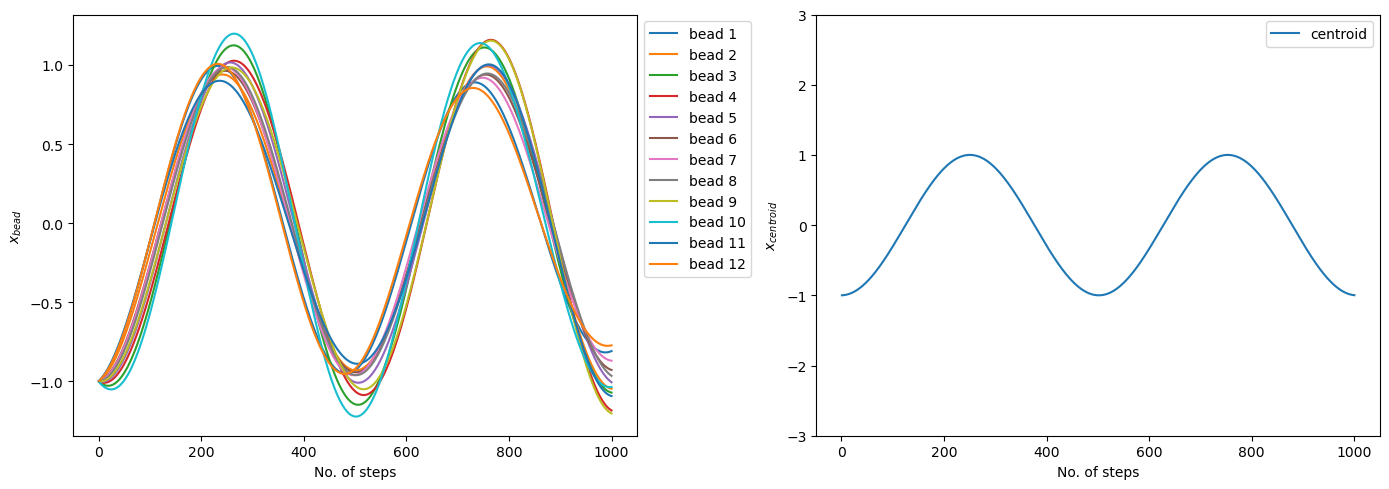

In [40]:
# Plot how the individual bead coordinates change during the above short simulation

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

for bead in range(P):
    ax1.plot(np.linspace(1,totalSteps,totalSteps), qq[:,bead], '-', label=r'bead '+str(bead+1))
ax1.legend(bbox_to_anchor=(1.,1))
ax1.set_xlabel('No. of steps')
ax1.set_ylabel(r'$x_{bead}$')

ax2.plot(np.linspace(1,totalSteps,totalSteps), centroid, '-', label=r'centroid')
ax2.legend(bbox_to_anchor=(1.,1))
ax2.set_xlabel('No. of steps')
ax2.set_ylabel(r'$x_{centroid}$')
ax2.set_ylim([-3,3])

plt.tight_layout()
plt.show()

### Challenge:

1. Plot ring polymer radius of gyration with respect to inverse temperature, $\beta$
2. Plot ring polymer radius of gyration with respect to number of beads, $P$
3. Plot timestep vs conserved energy
4. Plot number of beads vs conserved energy